# Maximum Independent Set
Quantum Optimization Benchmark Library: https://doi.org/10.48550/arXiv.2504.03832

s. also here: https://github.com/eggerdj/independent_set_benchmarking/blob/main/notebooks/independent_set_sparrow.ipynb

Hardware: Apple M1 Pro (8 cores, 16 GB memory)

## Benchmark

In [ ]:
using Quicopt, LinearAlgebra
using CPUTime
using Printf
using PythonPlot
Base.show(io::IO, f::Float64) = @printf(io, "%1.5f", f)

In [3]:
function load_dimacs_graph_matrix(filepath::String)
    num_nodes = 0
    adj_matrix = falses(0, 0) # Initialize as an empty BitMatrix

    open(filepath, "r") do file_stream
        for line in eachline(file_stream)
            parts = split(line)
            isempty(parts) && continue # Skip empty or whitespace-only lines
            # println(parts)

            token = parts[1]
            if token == "p" && length(parts) >= 3 && parts[2] == "edge"
                num_nodes = parse(Int, parts[3])
                adj_matrix = falses(num_nodes, num_nodes)
            elseif token == "e" && length(parts) >= 3 && num_nodes > 0
                u = parse(Int, parts[2])
                v = parse(Int, parts[3])
                # Assuming 1-based indexing and valid u,v as per DIMACS
                adj_matrix[u, v] = true
                adj_matrix[v, u] = true # Undirected graph
            end
            # Comment lines (starting with 'c') or other lines are implicitly ignored.
        end
    end
    
    return adj_matrix
end

load_dimacs_graph_matrix (generic function with 1 method)

In [4]:
PATH = "../../instances/max_independent_set/"
filename = "aves-sparrow-social.gph";

In [5]:
# load graph from file
graph = load_dimacs_graph_matrix(PATH * filename)

# system size
N = size(graph)[1]

# Lagrange multiplier
λ = 2.0

# cost function
local_fields = -ones(N) + 0.5λ .* (ones(N)' * graph)';
couplings = -0.5λ .* graph

tensor_problem = TensorProblem(local_fields, couplings);

In [6]:
# solver parameters
T = 2.0^7;

In [8]:
# run to force precompilation
mf_sol = solve(tensor_problem, T)
sol_vec = sign.(mf_sol.u[end][3, :]);

In [9]:
# get CPU time
@CPUtime begin
    mf_sol = solve(tensor_problem, T)
    sol_vec = sign.(mf_sol.u[end][3, :])
end;

elapsed CPU time: 0.06065 seconds


In [10]:
# energy
E = 0.5 .* (sol_vec' * couplings * sol_vec) + local_fields' * sol_vec |> println

428.00000


In [11]:
# map from Ising to binary
bit_string = (1 .- sol_vec) ./ 2

# check violated clauses
bit_string' * graph * bit_string |> println

# check max. indep. set
sum(bit_string) |> println

0.00000
13.00000


In [12]:
bit_string .|> Int |> println

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]


## Plot trajectories

In [13]:
times = range(0, T, 513)
plot_data_nz = reduce(hcat, [mf_sol(t)[3, 1:min(N, 20)] for t in times]);

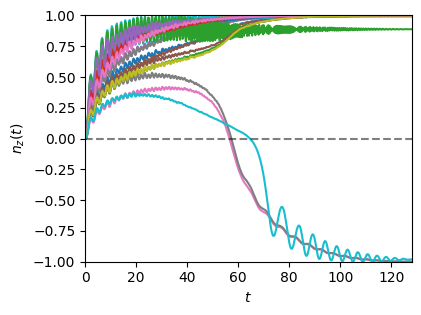

In [14]:
figure(figsize=(4, 3))
for k in 1:size(plot_data_nz)[1]
    plot(times, plot_data_nz[k, :])
end
axhline(0., color="k", alpha=0.5, ls="--")
tight_layout()
xlabel("\$t\$")
ylabel("\$ n_z(t)\$")
xlim(times[1], times[end])
ylim(-1, 1)
display(gcf())
PythonPlot.close();